# PYMC

[PYMC](https://www.pymc.io/welcome.html) is one of several libraries in Python for _probabilistic programming._  In practice, it's also very widely used for Bayesian statistical modeling.  This is something I'm not familiar enough with to teach in any great detail, but here's the extremely abridged version of Bayesian modeling as I understand it.

The statistical models you're probably used to, like Ordinary Least Squares regression, all return _point estimates_ for their parameters.  These are usually the values that maximize some quantity, e.g., they maximize the likelihood of the data.  However, it is often helpful to have a distribution of possible values for these estimates, rather than just a single number/point estimate: rather than "the slope is 5.5," it can be nice to know how likely it is to be a different value, like 3, or 10.  Bayesian modeling lets you do this: move away from point estimates, and start to estimate the probability distribution of your model's parameters.

Unfortunately, this ends up being far more computationally expensive.  There's a step in basically every Bayesian model where you have to draw a whole bunch of random samples to estimate those probability distributions; this can be very time-consuming, especially for complex models and large datasets.

If you do a lot of Bayesian modeling, PYMC is a very nice tool.  But it's definitelt worth giving the [Stan](https://mc-stan.org/) programming language a look (it's designed from the ground up to support probabilistic programming).  The [Julia](https://julialang.org/) programming language gets an honorable mention: it's a very easy-to-write, extremely fast-to-run language that's getting more and better probabilistic programming libraries each month.  (One of our last lectures might actually be about Julia).

Install PYMC with:

```bash
conda install -c conda-forge "pymc>=4"
```

**Note:** PYMC contains some code written in C++, which can be compiled for  _big_ speedup if you have a C++ compiler installed.  The above command should handle that and get everything intalled in your Conda environment.

**Note:** the above command seems to work best when run in a brand-new, fresh conda environment.  I had a few issues running it inside an existing environment.  You can create and install at the same time with:

```bash
conda create -n [environment_name] -c conda-forge "pymc>=4"
```

# PYMC Quickstart

Let's generate some data to work with:

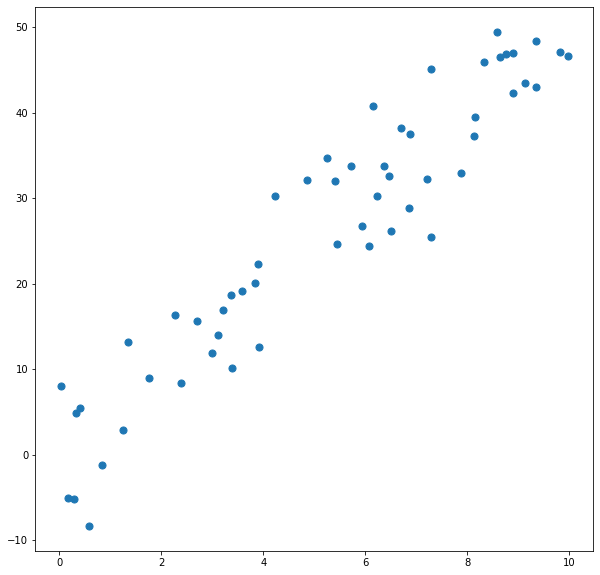

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

# Generate some linear data with normally-distributed noise.
rng = np.random.default_rng(seed=0)
x = rng.random(size=55) * 10
y = 5*x + rng.normal(loc=0, scale=5, size=x.shape[0])

fix, ax = plt.subplots(figsize=(10,10))
ax.scatter(x, y, s=50)
plt.show()

The basic sketch for building a PYMC model has a lot of moving parts, but the code is fairly simple.  We define the terms that our model has, create a PYMC object for those terms, create a model using those objects, and then sample a bunch of different posterior distributions.

In [2]:
with pm.Model() as liner_model:
    # Big standard deviations on these parameters,
    # since we may not have much prior information
    # about what they might be.
    coef = pm.Normal("coefficient", mu=0, sigma=20)
    intercept = pm.Normal("intercept", mu=0, sigma=20)
    noise = pm.Exponential("noise", lam=1)
    
    # Now, specify the way we think these are related
    # to our observed values.  Note that this is just
    # another distribution where we define the mu and sigma
    # values using the above random distributions.
    observed_y = pm.Normal(
        "observed_values",
        mu=coef*x + intercept,
        sigma=noise,
        observed=y,
    )
    
    # Sample the posterior.  This step can take a while if
    # you don't have the C/C++ compilers installed--up to a few minutes,
    # even for pretty simple models.
    trace = pm.sample(1000, cores=10)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [coefficient, intercept, noise]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 91 seconds.
The acceptance probability does not match the target. It is 0.8819, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8806, but should be close to 0.8. Try to increase the number of tuning steps.


A breakdown of those lines:

- `with pm.Model() as linear_model` uses Python's context manager syntax--which PYMC models are designed to work with--to create a new temporary scope/context, which is controlled by the model.  The model will essentially "intercept" any lines of code that create variables, and will automatically add those to the model for us.  We could create a model without a context manager like this, but it would be a little more code.  Mostly, we'd have to manually add each term to the model after we create it.
- The next three non-commented lines create some variables.  Variables in PYMC are all described by the distributions they're drawn from, so we have two drawn from normal distributions and one from an exponential distribution.  The first argument to each of these consructors is just a string that will be used to identify that variable internally.  (so we have a variable in our local scope called "coef," but when the model is doing its work behind the scenes, it calls it "coefficient").  These variables will get caught by the context manager, and assigned automatically into the `pm.Model()` instance.
- The line where we create the `observed_y` variable is, as far as the code is concerned, basically identical to the previous three lines.  We're just setting the `mu` and `sigma` values based on the variables we created in the preceding lines.  This ends up saying that the `observed_y` value is a normally-distributed random variable, whose mean is drawn from the distribution that results from `coef*x + intercept`.
- At this point, the model has an internal _computation graph_ (or something like it): it knows how the different variables are related to each other, so it can start doing computations and randomly sampling the posterior distributions.  We could add more variables to the model if we wanted to, but with this example, there aren't any more terms that it makes sense to add.
- `pm.sample()` tells the current model (which, remember, is the model we created in the `with` statement, and which is controllin the current context) to start sampling posterior distributions.  The first (positional) parameter, 1000, says to draw 1,000 sample.  The second, `cores`, says to sample from 4 Markov chains in parallel; the total number of chains used defaults to either the number of cores or 2, whichever is higher.

Like I said, a lot of moving parts.  The use of context managers here is clever and convenient, but is also not a super common way for context managers to be used in Python.  The model creating an internal computation graph is also a bit unusual, and it results in us not explicitly specifying _what gets sampled_ when we call `pm.sample()`.  Most of the rest of the complexity comes from the nature of Bayesian modeling, rather than the Python code.

Once the sampling has finished, PYMC can automatically use the `trace` object to generate plots showing the estimated distribution of model parameters.  Note: basically all of PYMC's plotting functions just dispatch to the [ArviZ](https://arviz-devs.github.io/arviz/) library, which is specifically designed for visualizing Bayesian models, so check the documentation there for the arguments to functions like `plot_trace()`.

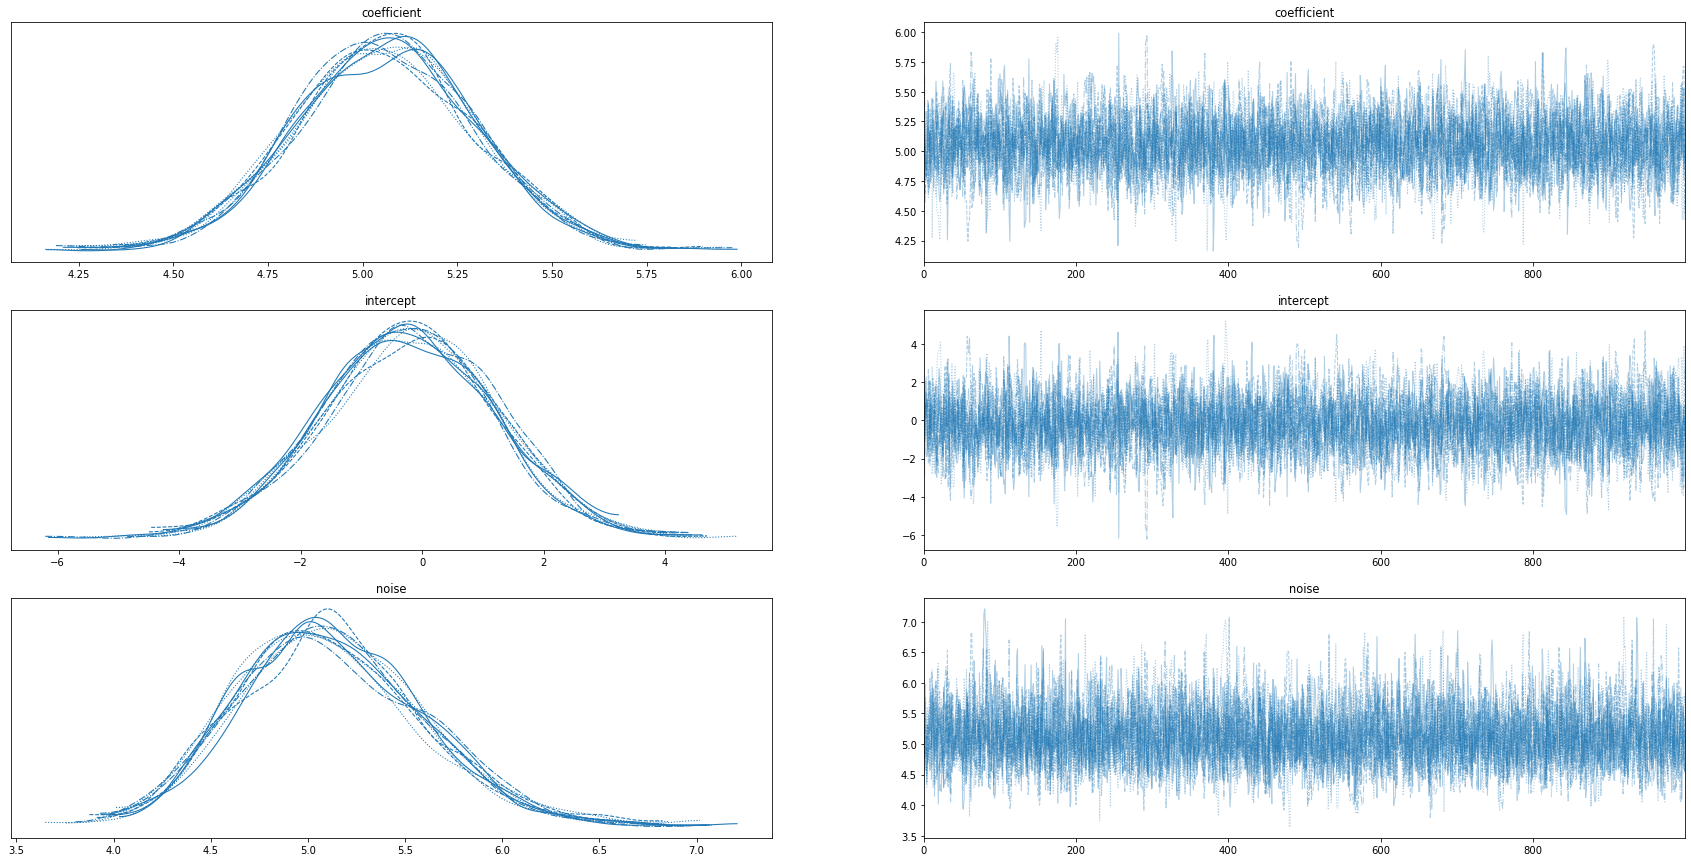

In [3]:
pm.plot_trace(trace, figsize=(30, 15))
plt.show()

The left hand side of these plots shows us the distributions over each parameter, with one line per Markov chain that was used for the random sampling step.  I'm not 100% sure what the right side is showing, so I'm going to ignore it.  Note that the left-hand charts are showing _distributions over likely values for the model parameters._  E.g.: rather than saying "the coefficient is 5, with a standard error of 0.25" (like an R or Statsmodels-type linear regression might), this shows us _lots_ more detail about the full distribution of values and how "reasonable" each one is, given the data we provided.

This is where my knowledge of Bayesian modeling and PYMC runs out, so any further reading will have to be done on your own.